In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/kaggle/input/weather-csv/weather_dataset.csv')
X = df.iloc[:, :-1].values.reshape(-1, 224, 224, 3)  # Reshape to (samples, 224, 224, 3)
y = tf.keras.utils.to_categorical(df['label'], num_classes=5)  # Convert labels to one-hot encoding

# Split into training, validation, and testing sets
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [2]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)


In [3]:
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model_xception.trainable = False

# Add custom layers
x = base_model_xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
predictions = Dense(5, activation='softmax')(x)

# Final model
model_xception = Model(inputs=base_model_xception.input, outputs=predictions)


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=15,          # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore weights of the best epoch
)


optimizer = Adam(learning_rate=0.001)
model_xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Train Xception
history_xception = model_xception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100, 
    callbacks=[early_stopping]
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733238402.406005      94 service.cc:145] XLA service 0x7ff2400043f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733238402.406079      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.2422 - loss: 1.6433 

I0000 00:00:1733238409.781440      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 628ms/step - accuracy: 0.3550 - loss: 1.4805 - val_accuracy: 0.6578 - val_loss: 1.0479
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - accuracy: 0.6659 - loss: 0.9440 - val_accuracy: 0.7422 - val_loss: 0.8365
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - accuracy: 0.7664 - loss: 0.7481 - val_accuracy: 0.7467 - val_loss: 0.7142
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 311ms/step - accuracy: 0.7869 - loss: 0.6370 - val_accuracy: 0.7867 - val_loss: 0.6659
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.8140 - loss: 0.5731 - val_accuracy: 0.7778 - val_loss: 0.6284
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 317ms/step - accuracy: 0.8454 - loss: 0.4855 - val_accuracy: 0.8178 - val_loss: 0.6049
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 310ms/step - accuracy: 0.8484 - loss: 0.5185 - val_accuracy: 0.8222 - val_loss: 0.5336
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.8632 - loss: 0.4569 - val_accuracy

In [5]:
# Normalize test data
X_test = X_test / 255.0

In [6]:
# Evaluate Xception
xception_loss, xception_acc = model_xception.evaluate(X_test, y_test)
print(f"Xception - Loss: {xception_loss}, Accuracy: {xception_acc}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.8453 - loss: 0.4929
Xception - Loss: 0.4760088324546814, Accuracy: 0.8577777743339539


In [7]:
# Evaluate Xception
xception_loss, xception_acc = model_xception.evaluate(val_generator)
print(f"Xception - Loss: {xception_loss}, Accuracy: {xception_acc}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.8685 - loss: 0.3878
Xception - Loss: 0.44122782349586487, Accuracy: 0.8444444537162781


In [8]:
# Evaluate Xception
xception_loss, xception_acc = model_xception.evaluate(train_generator)
print(f"Xception - Loss: {xception_loss}, Accuracy: {xception_acc}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 327ms/step - accuracy: 0.9158 - loss: 0.2556
Xception - Loss: 0.24829722940921783, Accuracy: 0.9219047427177429


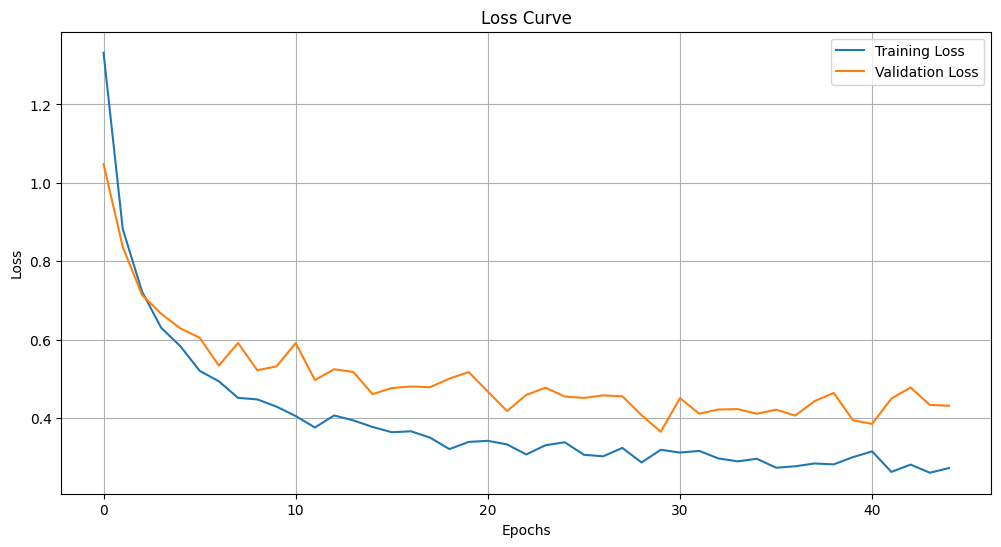

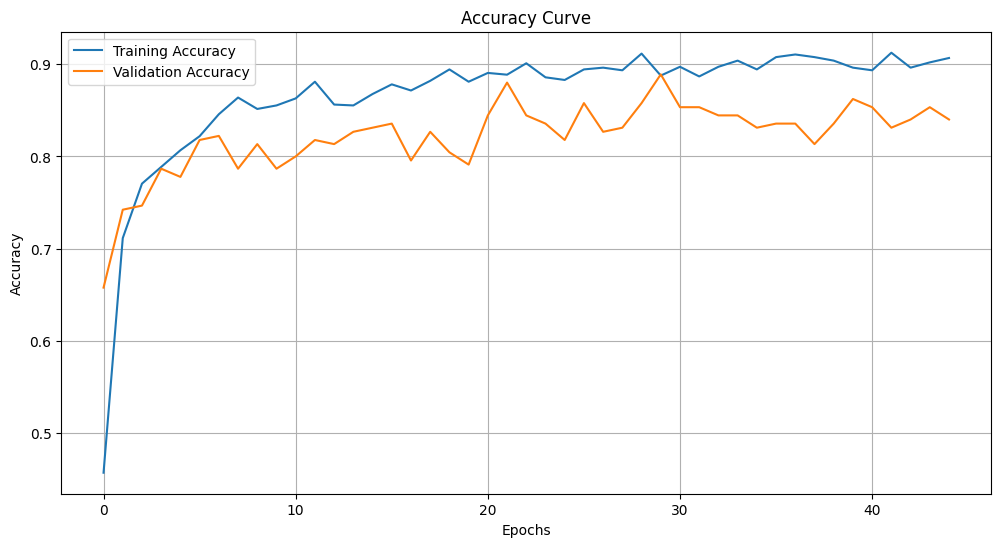

In [15]:
train_loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
train_acc = history_xception.history['accuracy']
val_acc = history_xception.history['val_accuracy']

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict probabilities for both models
y_pred_xception = model_xception.predict(X_test)


# Convert probabilities to class predictions
y_pred_xception_classes = np.argmax(y_pred_xception, axis=1)

# True labels
y_true = np.argmax(y_test, axis=1)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step


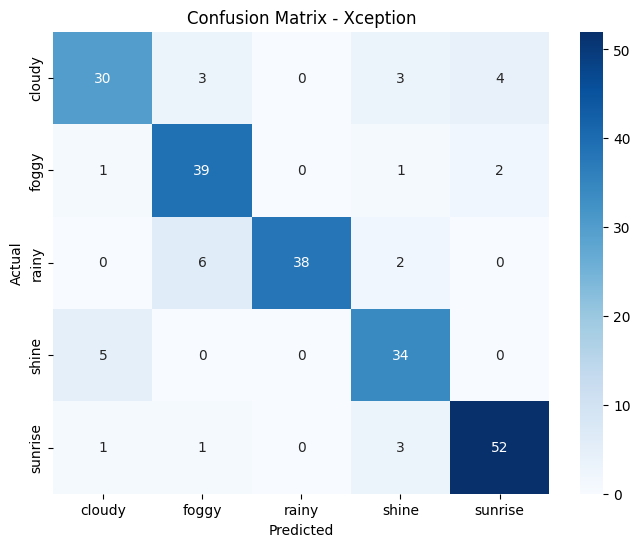

In [10]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Class names
class_names = ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']

# Plot for Xception
plot_confusion_matrix(y_true, y_pred_xception_classes, class_names, "Xception")



In [11]:
# Xception metrics
print("Xception Classification Report")
print(classification_report(y_true, y_pred_xception_classes, target_names=class_names))

Xception Classification Report
              precision    recall  f1-score   support

      cloudy       0.81      0.75      0.78        40
       foggy       0.80      0.91      0.85        43
       rainy       1.00      0.83      0.90        46
       shine       0.79      0.87      0.83        39
     sunrise       0.90      0.91      0.90        57

    accuracy                           0.86       225
   macro avg       0.86      0.85      0.85       225
weighted avg       0.86      0.86      0.86       225



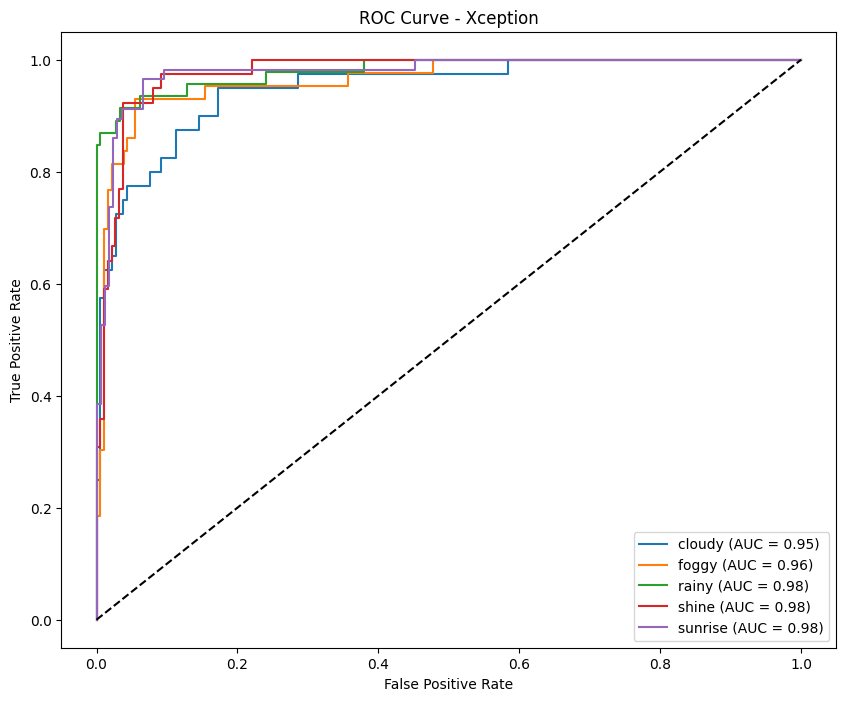

In [12]:
def plot_roc_curve(y_true, y_pred_probs, class_names, model_name):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC for Xception
plot_roc_curve(y_test, y_pred_xception, class_names, "Xception")




In [13]:
# Accuracy for Xception
xception_accuracy = np.mean(y_true == y_pred_xception_classes)
print(f"Xception Accuracy: {xception_accuracy:.2f}")



Xception Accuracy: 0.86


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Xception Metrics
precision_xception = precision_score(y_true, y_pred_xception_classes, average='weighted')
recall_xception = recall_score(y_true, y_pred_xception_classes, average='weighted')
f1_xception = f1_score(y_true, y_pred_xception_classes, average='weighted')

print(f"Xception - Precision: {precision_xception:.2f}, Recall: {recall_xception:.2f}, F1-Score: {f1_xception:.2f}")


Xception - Precision: 0.86, Recall: 0.86, F1-Score: 0.86
